In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [2]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

print(df.columns)

Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'sequence', 'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc',
       ...
       '9_wm_pssm_K', '9_wm_pssm_M', '9_wm_pssm_F', '9_wm_pssm_P',
       '9_wm_pssm_S', '9_wm_pssm_T', '9_wm_pssm_W', '9_wm_pssm_Y',
       '9_wm_pssm_V', 'p_interface'],
      dtype='object', length=138)


In [3]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
p_interface
0    57304
1     7845
Name: count, dtype: int64


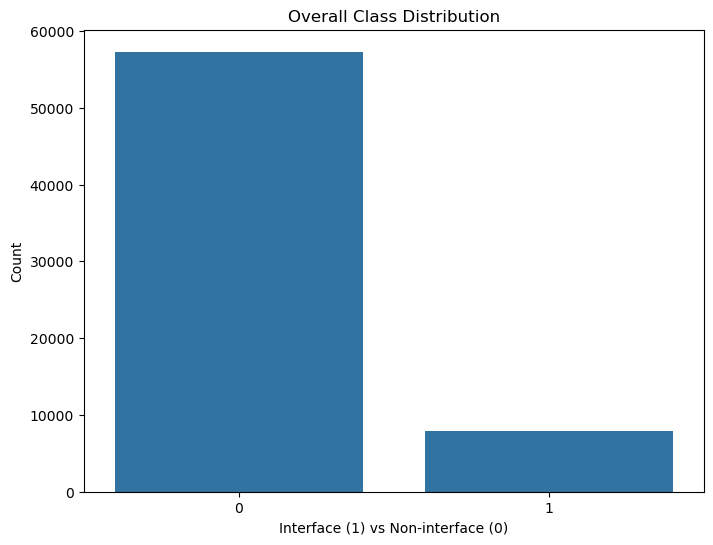

In [4]:
######################################################## check overall class distrubution
# Check overall class distribution for the target
target = "p_interface"
class_counts = df[target].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [5]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 90% train and 10% temporary (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.10, random_state=42)

# Second split: Split the temporary groups into validation and test equally (5% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [6]:
####################################### calcualte class weight of train
class_weights = compute_class_weight("balanced", classes=np.unique(y_val), y=y_val)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_val), class_weights)}
print(class_weights)

{0: 0.6709163346613546, 1: 1.9627039627039626}


In [7]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 205
Unique uniprot_ids in Validation: 11
Unique uniprot_ids in Test: 12


In [8]:
######################################### undersampelin
# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# apply the undersampler on the training data
X_train, y_train = rus.fit_resample(X_train, y_train)


# shape of the training data before and after undersampling
print("Undersampled training set shape:", X_train.shape, y_train.shape)
print("Undersampled val set shape:", X_val.shape, y_val.shape)
print("Undersampled test set shape:", X_test.shape, y_test.shape)

print("Origina dataset columns:")
print(df.columns)

print("Train set columns:")
print(X_train.columns)

print("\nValidation set columns:")
print(X_val.columns)

print("\nTest set columns:")
print(X_test.columns)

Undersampled training set shape: (13808, 151) (13808,)
Undersampled val set shape: (1684, 151) (1684,)
Undersampled test set shape: (3647, 151) (3647,)
Origina dataset columns:
Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc', 'prob_sheet',
       ...
       'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W',
       'aa_Y'],
      dtype='object', length=157)
Train set columns:
Index(['normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc', 'prob_sheet',
       'prob_helix', 'prob_coil', 'pssm_A', 'pssm_R', 'pssm_N',
       ...
       'aa_M', 'aa_N', 'aa_P', 'aa_Q', 'aa_R', 'aa_S', 'aa_T', 'aa_V', 'aa_W',
       'aa_Y'],
      dtype='object', length=151)

Validation set columns:
Index(['normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc', 'prob

C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [9]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
#################################################### Linear regression

# Initialize and fit the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

#y_pred_LR = model.predict(X_test)
y_pred_LR = model.predict_proba(X_test)[:, 1]

# Convert continuous predictions to binary class labels using a threshold of 0.5
y_pred_class_LR = (y_pred_LR >= 0.5).astype(int)

# Evaluate the classifier
accuracy_LR = accuracy_score(y_test, y_pred_class_LR)
precision_LR = precision_score(y_test, y_pred_class_LR, zero_division=0)
recall_LR = recall_score(y_test, y_pred_class_LR, zero_division=0)
f1_LR = f1_score(y_test, y_pred_class_LR, zero_division=0)


C:\Users\youpz\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.78
Precision: 0.29
Recall: 0.40
F1 Score: 0.34
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3135
           1       0.29      0.40      0.34       512

    accuracy                           0.78      3647
   macro avg       0.59      0.62      0.60      3647
weighted avg       0.81      0.78      0.79      3647



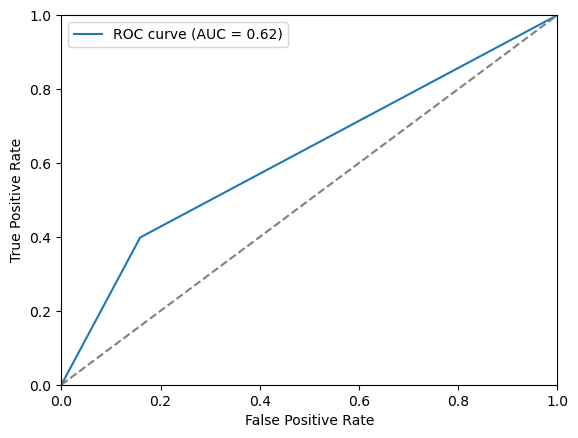

In [11]:
################################################## print results Linear regression

print(f"Accuracy: {accuracy_LR:.2f}")
print(f"Precision: {precision_LR:.2f}")
print(f"Recall: {recall_LR:.2f}")
print(f"F1 Score: {f1_LR:.2f}")

# Compute ROC curve with continuous probabilities
print(classification_report(y_test, y_pred_class_LR, zero_division=0))
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_class_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [12]:
###################################################### hyperparamtater tuning Random Foretst
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='accuracy',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Validation Accuracy (RF): 0.6590716405256465


In [13]:
################################################# get best scores hyperparamter 
y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

Accuracy: 0.85
Precision: 0.17
Recall: 0.01
F1 Score: 0.02
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3135
           1       0.17      0.01      0.02       512

    accuracy                           0.85      3647
   macro avg       0.51      0.50      0.47      3647
weighted avg       0.76      0.85      0.79      3647



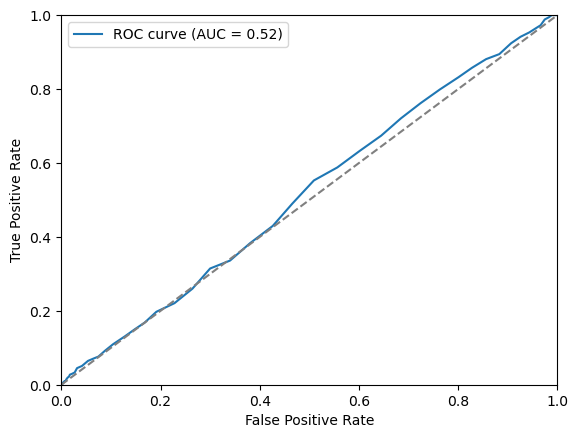

In [14]:
############################################################### print score radndom forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [15]:
############################################### hyper paramter tuning XGBoost

param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_XGB = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight=class_weights),
    param_grid_XGB, 
    scoring='accuracy',
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]


----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.6916790306627101


C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
############################################### running XGBoost

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)



XGBoost Classifier Performance:
Accuracy: 0.86
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      3135
           1       0.00      0.00      0.00       512

    accuracy                           0.86      3647
   macro avg       0.43      0.50      0.46      3647
weighted avg       0.74      0.86      0.79      3647



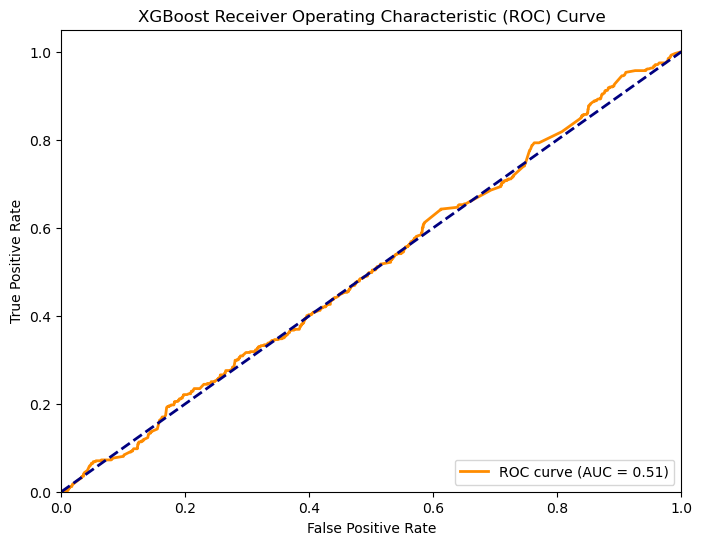

In [17]:
############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
################################################## make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])



C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
###################################################### train model and set the class weights



history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)


Epoch 1/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5360 - auc: 0.5572 - loss: 0.9640 - val_accuracy: 0.3533 - val_auc: 0.5691 - val_loss: 1.0107
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5592 - auc: 0.6422 - loss: 0.7317 - val_accuracy: 0.3664 - val_auc: 0.5799 - val_loss: 1.0421
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5768 - auc: 0.6773 - loss: 0.6985 - val_accuracy: 0.3670 - val_auc: 0.5751 - val_loss: 1.0746
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5835 - auc: 0.6843 - loss: 0.6871 - val_accuracy: 0.3901 - val_auc: 0.5890 - val_loss: 1.0320
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5967 - auc: 0.7115 - loss: 0.6678 - val_accuracy: 0.3854 - val_auc: 0.6084 - val_loss: 1.0633
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5901 - auc: 0.7153 - loss: 0.6690 - val_accuracy: 0.3783 - val_auc: 0.5882 - val_loss: 1.0805
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
####################################################### caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# 2. Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)



114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy: 0.58
Precision: 0.21
Recall: 0.72
F1 Score: 0.32

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      3135
           1       0.21      0.72      0.32       512

    accuracy                           0.58      3647
   macro avg       0.57      0.64      0.51      3647
weighted avg       0.82      0.58      0.64      3647



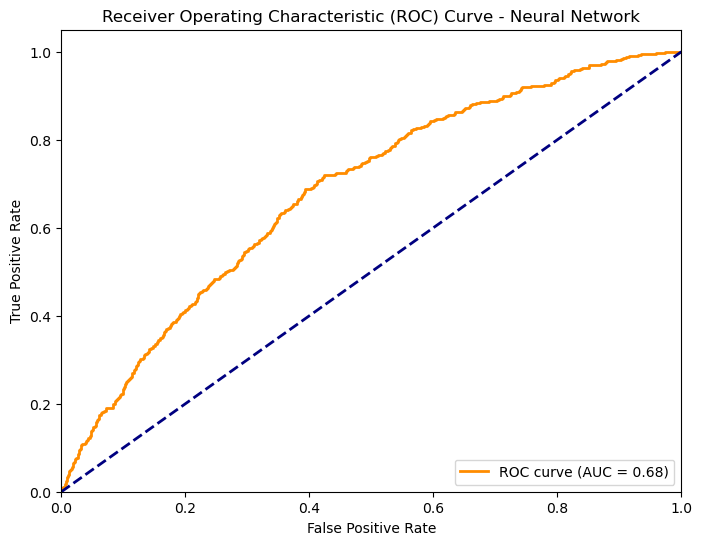

In [21]:
######################################################## print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# 5. Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

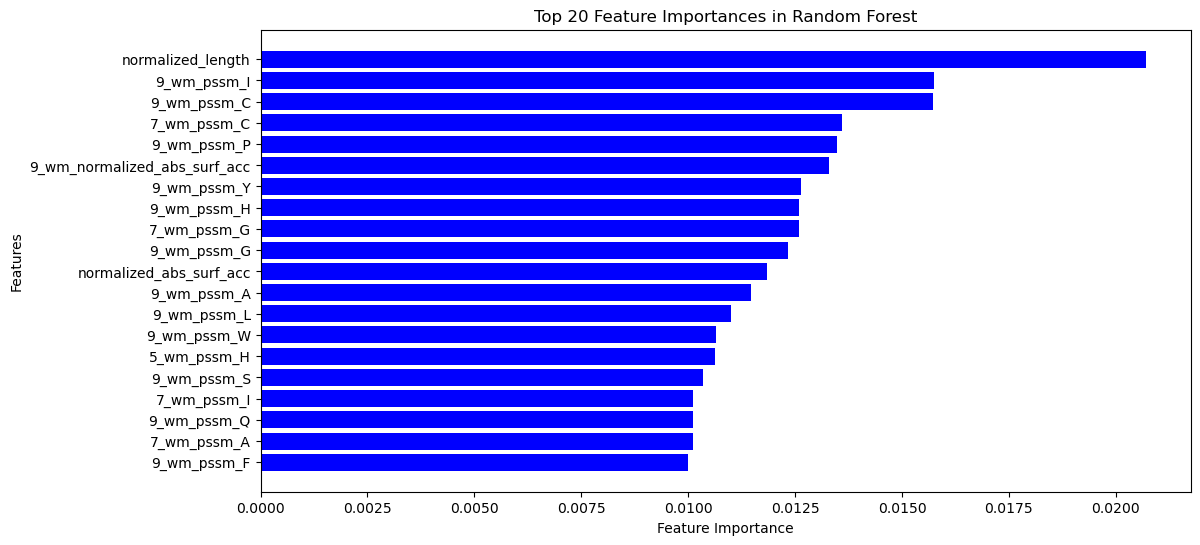

In [23]:
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names = train_df_test.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_train_names = pd.DataFrame(X_train, columns=feature_names)



# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()
